# Primera entrega NBA Salaries

Integrantes:

- Nicolas Biojo
- Cristian Cobo
- David Erazo

# Limpieza

In [67]:
import pandas as pd
import seaborn as sn
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

In [59]:
data = pd.read_csv('2017-18_NBA_salary.csv')
data.head()

,Player,Salary,NBA_Country,NBA_DraftNumber,Age,Tm,G,MP,PER,TS%,...,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
0,Zhou Qi,815615,China,43,22,HOU,16,87,0.6,0.303,...,18.2,19.5,-0.4,0.1,-0.2,-0.121,-10.6,0.5,-10.1,-0.2
1,Zaza Pachulia,3477600,Georgia,42,33,GSW,66,937,16.8,0.608,...,19.3,17.2,1.7,1.4,3.1,0.160,-0.6,1.3,0.8,0.7
2,Zach Randolph,12307692,USA,19,36,SAC,59,1508,17.3,0.529,...,12.5,27.6,0.3,1.1,1.4,0.046,-0.6,-1.3,-1.9,0.0
3,Zach LaVine,3202217,USA,13,22,CHI,24,656,14.6,0.499,...,9.7,29.5,-0.1,0.5,0.4,0.027,-0.7,-2.0,-2.6,-0.1
4,Zach Collins,3057240,USA,10,20,POR,62,979,8.2,0.487,...,15.6,15.5,-0.4,1.2,0.8,0.038,-3.7,0.9,-2.9,-0.2


In [60]:
data["NBA_Country"].unique()

array(['China', 'Georgia', 'USA', 'Canada', 'Spain', 'France',
       'Czech Republic', 'Russia', 'South Sudan', 'Switzerland',
       'New Zealand', 'Haiti', 'Democratic Re_', 'Tunisia', 'Brazil',
       'Germany', 'Australia', 'Cameroon', 'Israel', 'Turkey',
       'United Kingdo...', 'Montenegro', 'Serbia', 'Argentina', 'Bosnia',
       'Lithuania', 'Croatia', 'Italy', 'Poland', 'Dominican Rep...',
       'Finland', 'Latvia', 'Bosnia & Herz...', 'Sweden', 'Ukraine',
       'Austria', 'Puerto Rico', 'Senegal', 'Slovenia', 'Greece',
       'Democratic Re...', 'Mali', 'Bahamas', 'Egypt'], dtype=object)

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 485 entries, 0 to 484
Data columns (total 28 columns):
Player             485 non-null object
Salary             485 non-null int64
NBA_Country        485 non-null object
NBA_DraftNumber    485 non-null int64
Age                485 non-null int64
Tm                 485 non-null object
G                  485 non-null int64
MP                 485 non-null int64
PER                485 non-null float64
TS%                483 non-null float64
3PAr               483 non-null float64
FTr                483 non-null float64
ORB%               485 non-null float64
DRB%               485 non-null float64
TRB%               485 non-null float64
AST%               485 non-null float64
STL%               485 non-null float64
BLK%               485 non-null float64
TOV%               483 non-null float64
USG%               485 non-null float64
OWS                485 non-null float64
DWS                485 non-null float64
WS                 485 non-n

In [38]:
#print("Missing colums: ",pd.isnull(data).any(0).to_numpy().nonzero()[0])
#print("Missing colums: ", data.columns[pd.isnull(data).any(0).to_numpy().nonzero()[0]])
mColums = pd.isnull(data).any(0).to_numpy().nonzero()[0]
print("Missing colums: ")
for col in mColums:
    print ("  index {} name {}".format(col,data.columns[col]))

Missing colums: 
  index 9 name TS%
  index 10 name 3PAr
  index 11 name FTr
  index 18 name TOV%


In [40]:
indices = pd.isnull(data).any(1).to_numpy().nonzero()[0]
print("{} incomplete records:".format(len(indices)), indices)

2 incomplete records: [29 37]


In [41]:
clean_data = data.dropna()
print("Datos originales: ", data.shape)
print("Datos limpios y completos: ", clean_data.shape)
print("Se eliminaron {} registos".format(data.shape[0] - clean_data.shape[0]))

Datos originales:  (485, 28)
Datos limpios y completos:  (483, 28)
Se eliminaron 2 registos


In [42]:
clean_data.describe()

,Salary,NBA_DraftNumber,Age,G,MP,PER,TS%,3PAr,FTr,ORB%,...,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
count,4.830000e+02,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,...,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000
mean,6.660622e+06,29.395445,26.273292,50.370600,1158.915114,13.315735,0.535387,0.337383,0.263404,4.893996,...,13.140373,18.975569,1.280745,1.181366,2.465424,0.080325,-1.252588,-0.489441,-1.741822,0.601242
std,7.398214e+06,21.116033,4.274290,24.723561,809.627553,8.745666,0.112352,0.226894,0.294578,4.581519,...,6.115290,5.826533,1.883545,1.033939,2.674520,0.163229,5.028752,2.394156,5.665905,1.247636
min,4.608000e+04,1.000000,19.000000,1.000000,1.000000,-41.100000,0.000000,0.000000,0.000000,0.000000,...,0.000000,5.700000,-2.300000,0.000000,-1.200000,-1.063000,-36.500000,-14.300000,-49.200000,-1.300000
25%,1.471382e+06,10.500000,23.000000,29.500000,385.000000,9.800000,0.505500,0.167000,0.155000,1.800000,...,9.900000,15.000000,0.000000,0.300000,0.300000,0.040500,-2.600000,-1.700000,-3.500000,-0.100000
50%,3.218280e+06,25.000000,26.000000,59.000000,1151.000000,13.200000,0.545000,0.346000,0.231000,3.300000,...,12.500000,17.900000,0.800000,1.000000,1.900000,0.083000,-1.100000,-0.400000,-1.300000,0.100000
75%,1.000000e+07,47.000000,29.000000,71.000000,1824.500000,16.550000,0.582500,0.481000,0.319500,7.050000,...,15.750000,22.250000,2.000000,1.800000,3.600000,0.123000,0.400000,1.000000,0.550000,0.900000
max,3.468255e+07,62.000000,41.000000,79.000000,2898.000000,134.100000,1.500000,1.000000,5.333000,35.900000,...,66.700000,45.100000,11.400000,5.600000,15.000000,2.713000,68.700000,6.800000,54.400000,8.600000


# Visualización de datos

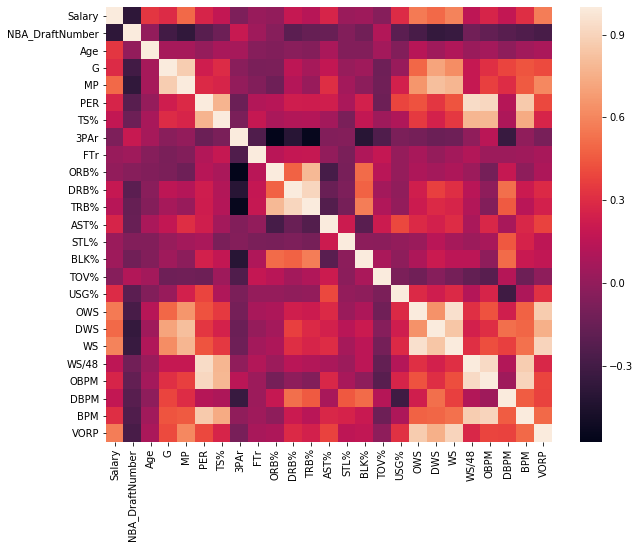

<Figure size 7200x4320 with 0 Axes>

In [43]:
fig = plt.figure(figsize=(10,8))
corrMatrix = clean_data.corr()
sn.heatmap(corrMatrix, annot=False)
plt.figure(figsize=(100,60))
plt.show()

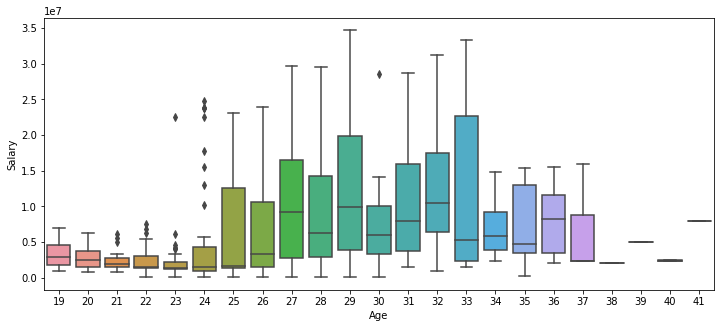

In [46]:
fig = plt.figure(figsize=(12,5))
sn.boxplot('Age', 'Salary', data=clean_data, orient='v')

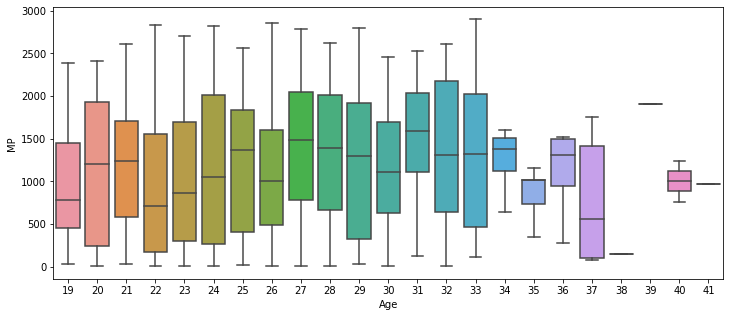

In [56]:
fig = plt.figure(figsize=(12,5))
sn.boxplot('Age', 'MP', data=clean_data, orient='v')

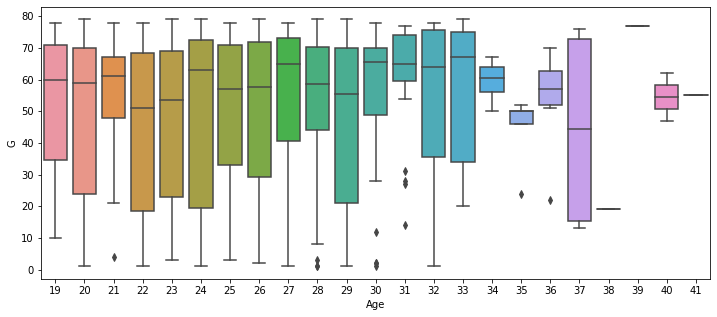

In [57]:
fig = plt.figure(figsize=(12,5))
sn.boxplot('Age', 'G', data=clean_data, orient='v')

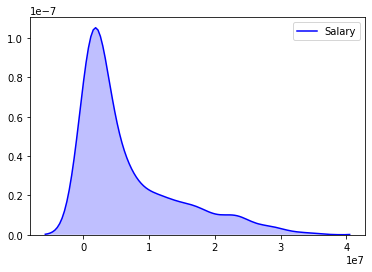

In [80]:
s = data.iloc[:,1]
ax = sn.kdeplot(s, shade=True, color="b")

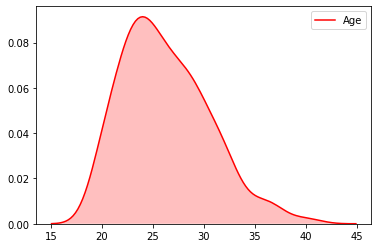

In [81]:
d = data.iloc[:,4]
ax = sn.kdeplot(d, shade=True, color="r")

In [ ]:
d = data.iloc[:,4]


In [ ]:
fig = plt.figure(figsize=(12,5))
sn.heatmap(corrMatrix[:1], annot=False)
plt.show()

In [ ]:
np.array(corrMatrix)[0:1,:]